<h1 style="text-align: center;">Pitch Classification Model</h1>

## Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib

## ML libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score

## visalization libraries
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

pd.options.display.max_columns = None

## Data Cleaning

In [2]:
def transform_tagged_pitches(pitch_type: str):
    """
    Maps the pitch of TaggedPitchType to be on the same wavelength as AutoPitchType
    """
    mapping = {'FourSeamFastBall': 'Four-Seam', 
               'Fastball': 'Four-Seam', 
               'TwoSeamFastBall': 'Sinker', 
               'ChangeUp': 'Changeup', 
               'Sweeper': 'Slider',
               'OneSeamFastBall': 'Sinker',
               }
    return mapping.get(pitch_type, pitch_type)

In [67]:
df = pd.read_csv('../../Files/merged_trackman_games.csv', dtype={'HomeTeamForeignID': str, 'AwayTeamForeignID': str}).drop(columns=['HomeTeamForeignID', 'AwayTeamForeignID']).copy()
# df = df[['Pitcher', 'PitcherThrows', 'PitcherTeam', 'TaggedPitchType', 'AutoPitchType', 
#          'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide',
#          'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']].copy()

## gets rid of the pitches without any data for it
df = df[~df['AutoPitchType'].isna()].reset_index(drop=True).copy()

## makes the pitch names be consistent
df['AutoPitchType'] = df.apply(lambda x: x['TaggedPitchType'] if x['AutoPitchType'] == 'Other' else x['AutoPitchType'], axis=1)
df['TaggedPitchType'] = df.apply(lambda x: 
                                 x['AutoPitchType'] 
                                 if (x['TaggedPitchType']=='Other' or x['TaggedPitchType']=='Knuckleball' or x['TaggedPitchType']=='Undefined')
                                 else x['TaggedPitchType'], axis=1)

df['TaggedPitchType'] = df['TaggedPitchType'].apply(transform_tagged_pitches)
df['AutoPitchType'] = df['AutoPitchType'].apply(transform_tagged_pitches)

## imputes the null values of Extension
df['Extension'] = df['Extension'].fillna(df.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam'])['Extension'].transform('mean'))
df['SpinRate'] = df['SpinRate'].fillna(df.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam', 'AutoPitchType'])['SpinRate'].transform('mean'))
## gets rid of any lingering null rows
df = df[~df['SpinRate'].isna()].reset_index(drop=True).copy()

df['PitcherThrows'] = df['PitcherThrows'].apply(lambda x: x=='Right').astype(int)
df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-02-21,14:02:52.36,1,1,"Elliott, Hunter",695545.0,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,0,Four-Seam,Sinker,StrikeCalled,Undefined,Undefined,Undefined,0,0,89.33355,-0.276997,4.350026,2203.614887,132.167696,10:30,5.22699,-2.68740,6.21670,-17.99422,17.21702,-17.58678,3.47110,-0.13083,80.25956,-3.747010,1.186737,0.427083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.39816,9.33898,2.36887,50.0,5.19704,-9.08953,-129.30922,-1.10744,17.34646,30.66937,-16.59455,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,d5791800-f08e-11ef-b516-25f8a7d41699,88.25556,NaN,NaN,9.07400,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:02:52.36,2025-02-21T14:02:52.3694080-06:00,2025-02-21T20:02:52.3694080Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Smithwick, Campbell",805802.0,Right,OLE_REB,ebd6f9a4-d844-4b8f-9733-c22c00229021,54.28077,-130.32058,15.33469,5.22454,-0.56022,-8.29728,2.67804,-9.66155,8.67323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2025-02-21,14:03:10.24,1,2,"Elliott, Hunter",695545.0,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,88.90840,-2.228576,3.686879,2183.741757,129.629962,10:15,5.21500,-2.74463,6.52932,-18.22198,17.10166,-18.99836,1.64677,-0.94085,79.64732,-5.761843,0.242888,0.427764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.08634,10.07721,2.49500,50.0,5.05170,-7.51835,-128.70615,-5.47001,18.19992,32.02154,-15.63076,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,e02220d0-f08e-11ef-b516-25f8a7d41699,88.11509,NaN,NaN,9.26108,NaN

In [68]:
display(df['TaggedPitchType'].unique())
display(df['AutoPitchType'].unique())
display(df.isna().sum())

array(['Four-Seam', 'Changeup', 'Slider', 'Curveball', 'Cutter', 'Sinker',
       'Splitter'], dtype=object)

array(['Sinker', 'Changeup', 'Four-Seam', 'Slider', 'Curveball',
       'Splitter', 'Cutter'], dtype=object)

PitchNo                                0
Date                                   0
Time                                   0
PAofInning                             0
PitchofPA                              0
                                   ...  
HitLaunchConfidence               178456
HitLandingConfidence              178456
CatcherThrowCatchConfidence       235947
CatcherThrowReleaseConfidence     235947
CatcherThrowLocationConfidence    235947
Length: 164, dtype: int64

## EDA

In [69]:
def pitch_type_group(pitch_type: str):
    """
    Maps out the pitch type and outputs its pitch group (e.g., 4S are fastballs, SL are breaking balls, etc.)
    """
    pitch_groups = {'Fastball': ['Sinker', 'Four-Seam', 'Cutter'],
                    'Breakingball': ['Slider', 'Curveball'],
                    'Offspeed': ['Changeup', 'Splitter']
                    }
    for k, v in pitch_groups.items():
        if pitch_type in v:
            return k
    return np.nan

In [70]:
## finds the pitch groups from each classification system
df['TaggedGroup'] = df['TaggedPitchType'].apply(pitch_type_group)
df['AutoGroup'] = df['AutoPitchType'].apply(pitch_type_group)

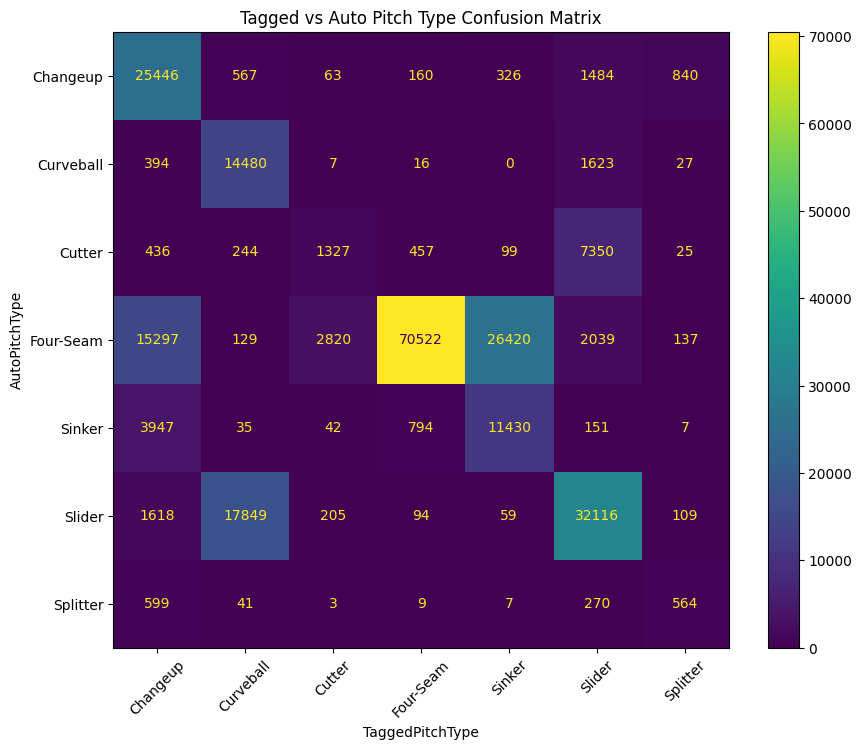

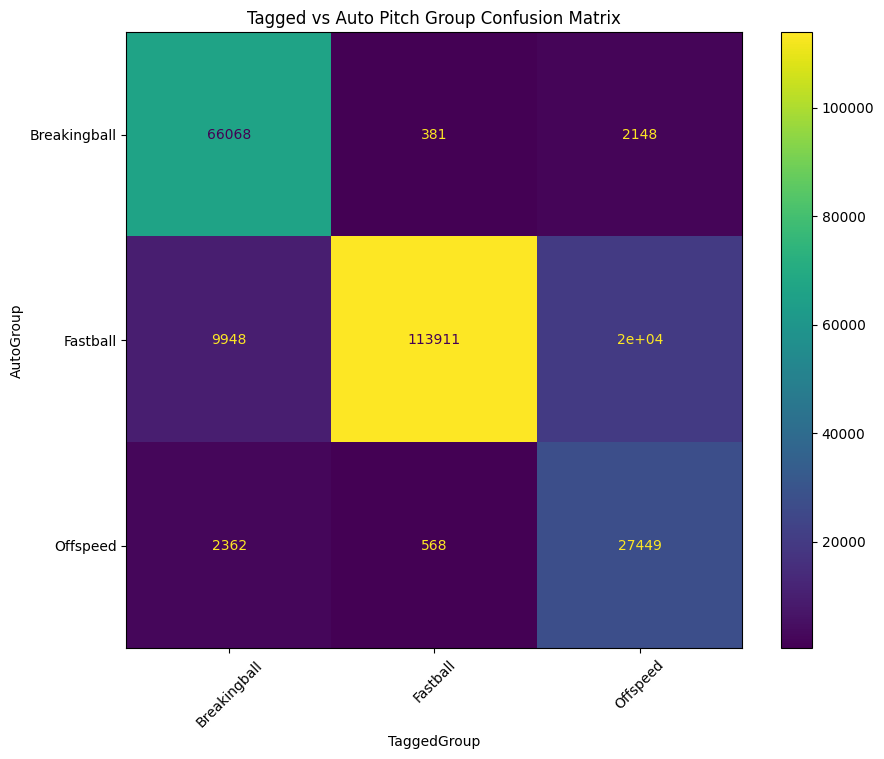

In [71]:
## individual pitches
labels = sorted(set(df["TaggedPitchType"].unique()) | set(df["AutoPitchType"].unique()))
cm = confusion_matrix(df["TaggedPitchType"], df["AutoPitchType"], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("TaggedPitchType")
ax.set_ylabel("AutoPitchType")
plt.title("Tagged vs Auto Pitch Type Confusion Matrix")
plt.show()

## pitch groups
group_labels = sorted(set(df["TaggedGroup"].unique()) | set(df["AutoGroup"].unique()))
group_cm = confusion_matrix(df["TaggedGroup"], df["AutoGroup"], labels=group_labels)
group_disp = ConfusionMatrixDisplay(confusion_matrix=group_cm, display_labels=group_labels)
fig, ax = plt.subplots(figsize=(10, 8))
group_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("TaggedGroup")
ax.set_ylabel("AutoGroup")
plt.title("Tagged vs Auto Pitch Group Confusion Matrix")
plt.show()

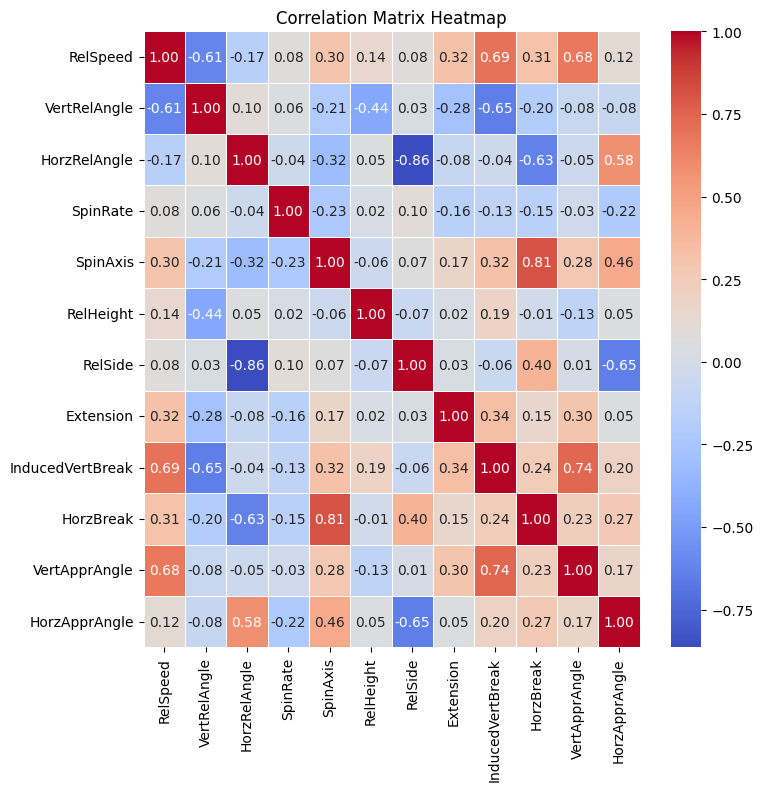

In [72]:
plt.figure(figsize=(8, 8)) 
correlation_matrix = df[['RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 
                         'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [73]:
training_data = df[df['TaggedGroup'] == df['AutoGroup']].reset_index(drop=True).copy()
training_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup
0,1,2025-02-21,14:02:52.36,1,1,"Elliott, Hunter",695545.0,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,0,Four-Seam,Sinker,StrikeCalled,Undefined,Undefined,Undefined,0,0,89.33355,-0.276997,4.350026,2203.614887,132.167696,10:30,5.22699,-2.68740,6.21670,-17.99422,17.21702,-17.58678,3.47110,-0.13083,80.25956,-3.747010,1.186737,0.427083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.39816,9.33898,2.36887,50.0,5.19704,-9.08953,-129.30922,-1.10744,17.34646,30.66937,-16.59455,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,d5791800-f08e-11ef-b516-25f8a7d41699,88.25556,NaN,NaN,9.07400,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:02:52.36,2025-02-21T14:02:52.3694080-06:00,2025-02-21T20:02:52.3694080Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Smithwick, Campbell",805802.0,Right,OLE_REB,ebd6f9a4-d844-4b8f-9733-c22c00229021,54.28077,-130.32058,15.33469,5.22454,-0.56022,-8.29728,2.67804,-9.66155,8.67323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball
1,2,2025-02-21,14:03:10.24,1,2,"Elliott, Hunter",695545.0,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,88.90840,-2.228576,3.686879,2183.741757,129.629962,10:15,5.21500,-2.74463,6.52932,-18.22198,17.10166,-18.99836,1.64677,-0.94085,79.64732,-5.761843,0.242888,0.427764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.08634,10.07721,2.49500,50.0,5.05170,-7.51835,-128.70615,-5.47001,18.19992,32.02154,-15.63076,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,e02220d0-f08e-11ef-b516-2

In [74]:
## 4-seam fastballs
training_data[training_data['TaggedPitchType']=='Four-Seam'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000
mean,89.831274,2213.447977,196.207945,17.079154,5.081637,5.870394,0.761623
std,2.637885,161.967552,33.738475,4.432129,10.559091,0.487207,1.555158
min,65.862420,1363.963756,64.858005,-20.815290,-28.662730,1.869790,-4.764440
25%,88.034700,2103.283681,176.580342,14.607717,-0.960770,5.586530,-0.088243
50%,89.716410,2212.729904,204.680326,17.578830,8.010595,5.871570,1.252045
75%,91.535690,2323.853973,218.937724,20.111430,12.841600,6.177668,1.819558
max,100.262930,2902.842162,343.373462,60.109250,29.050760,9.016000,5.630150


In [75]:
## Sinkers
training_data[training_data['TaggedPitchType']=='Sinker'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,90.233046,2172.544755,220.115172,9.688103,10.530101,5.465157,1.224397
std,2.201451,166.157084,51.653602,4.876301,13.736178,0.567880,1.726078
min,78.821640,1461.292453,63.876383,-16.228870,-28.656200,1.828870,-4.517350
25%,88.728507,2063.715236,224.576705,6.859620,11.996130,5.186608,1.055410
50%,90.044780,2173.741753,239.151975,9.992955,16.305580,5.546980,1.731475
75%,91.652360,2289.544355,250.393544,12.918547,18.765080,5.825627,2.251408
max,98.546720,2723.772881,327.356613,25.144900,30.729620,7.179750,4.803680


In [76]:
## cutters
training_data[training_data['TaggedPitchType']=='Cutter'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,87.650571,2307.754509,185.302066,11.671202,1.323642,5.881243,0.667963
std,2.611368,197.230176,23.927060,3.749584,4.733758,0.490249,1.747074
min,70.272910,1715.018507,79.720948,-2.096730,-17.535290,4.366140,-3.713220
25%,86.085435,2168.462087,170.518659,9.060380,-1.736650,5.579875,-1.348540
50%,87.728430,2300.308778,184.766451,11.417490,0.871060,5.893220,1.398770
75%,89.303740,2444.514000,199.067071,13.999930,3.654985,6.148875,1.902590
max,95.908080,2930.013098,275.916830,32.045060,24.439110,8.994260,4.246130


In [77]:
## changeups
training_data[training_data['TaggedPitchType']=='Changeup'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,26286.000000,26286.000000,26286.000000,26286.000000,26286.000000,26286.000000,26286.000000
mean,80.884770,1723.918865,204.731537,7.490581,5.483694,5.626600,0.597843
std,3.415711,315.708321,67.289714,5.432443,14.958511,0.537307,1.874664
min,60.728050,604.186184,6.142212,-14.232370,-29.402570,1.503200,-4.848210
25%,78.529185,1515.428355,126.274261,3.834608,-11.894110,5.343718,-1.385555
50%,81.063000,1723.826105,237.133961,7.672250,12.888690,5.632805,1.364615
75%,83.348348,1940.077545,255.116728,11.206570,17.096743,5.927442,1.977835
max,91.298420,3589.726921,358.537755,49.072230,30.161080,8.642400,5.698280


In [78]:
## splitters
training_data[training_data['TaggedPitchType']=='Splitter'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000
mean,82.104831,1261.215440,235.247905,4.634811,7.967025,5.780283,1.215872
std,3.228117,404.974647,59.390483,5.849806,9.051637,0.443989,1.232259
min,67.499240,614.165091,4.455092,-14.311030,-22.346740,4.322510,-3.248560
25%,79.871485,980.405888,224.263113,0.748680,5.774490,5.454305,0.849290
50%,82.032390,1187.070058,250.452232,4.123470,10.591030,5.788720,1.576720
75%,84.496690,1452.334552,271.269774,8.254570,13.933940,6.054815,2.030860
max,90.614800,3556.519809,351.264236,24.969070,22.690010,8.599880,3.744410


In [79]:
## Curveballs
training_data[training_data['TaggedPitchType']=='Curveball'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,16103.000000,16103.000000,16103.000000,16103.000000,16103.000000,16103.000000,16103.000000
mean,76.368778,2362.646771,111.365286,-8.561111,-5.232874,5.889830,0.796652
std,3.674741,293.420355,117.821304,6.465358,9.693507,0.467600,1.480675
min,51.059760,681.877148,0.018430,-27.490090,-28.821870,2.020110,-4.962930
25%,74.208390,2175.233476,33.649425,-13.192525,-12.195950,5.623525,0.232120
50%,76.519230,2364.180709,51.865986,-8.632010,-7.425400,5.897280,1.229290
75%,78.689155,2558.774986,146.777494,-4.243365,-0.295670,6.189540,1.818520
max,88.229960,3566.473881,359.985819,16.650880,31.066240,8.955200,5.664800


In [80]:
## Sliders
training_data[training_data['TaggedPitchType']=='Slider'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,49965.000000,49965.000000,49965.000000,49965.000000,49965.000000,49965.000000,49965.000000
mean,79.365713,2364.430163,133.993758,0.400662,-4.718012,5.629819,0.985371
std,3.709654,259.603323,87.649177,5.195758,9.413785,0.576624,1.756815
min,55.884090,695.596446,0.024484,-50.750300,-31.448800,1.647010,-5.067670
25%,77.073850,2202.697808,70.623856,-2.862640,-11.308710,5.338310,0.656030
50%,79.553400,2364.518198,98.950632,0.604250,-5.459960,5.660250,1.540760
75%,81.891520,2529.886334,185.510334,3.847480,0.235980,5.979940,2.110790
max,92.627390,3594.140484,359.981126,22.631430,28.546750,8.791950,6.034560


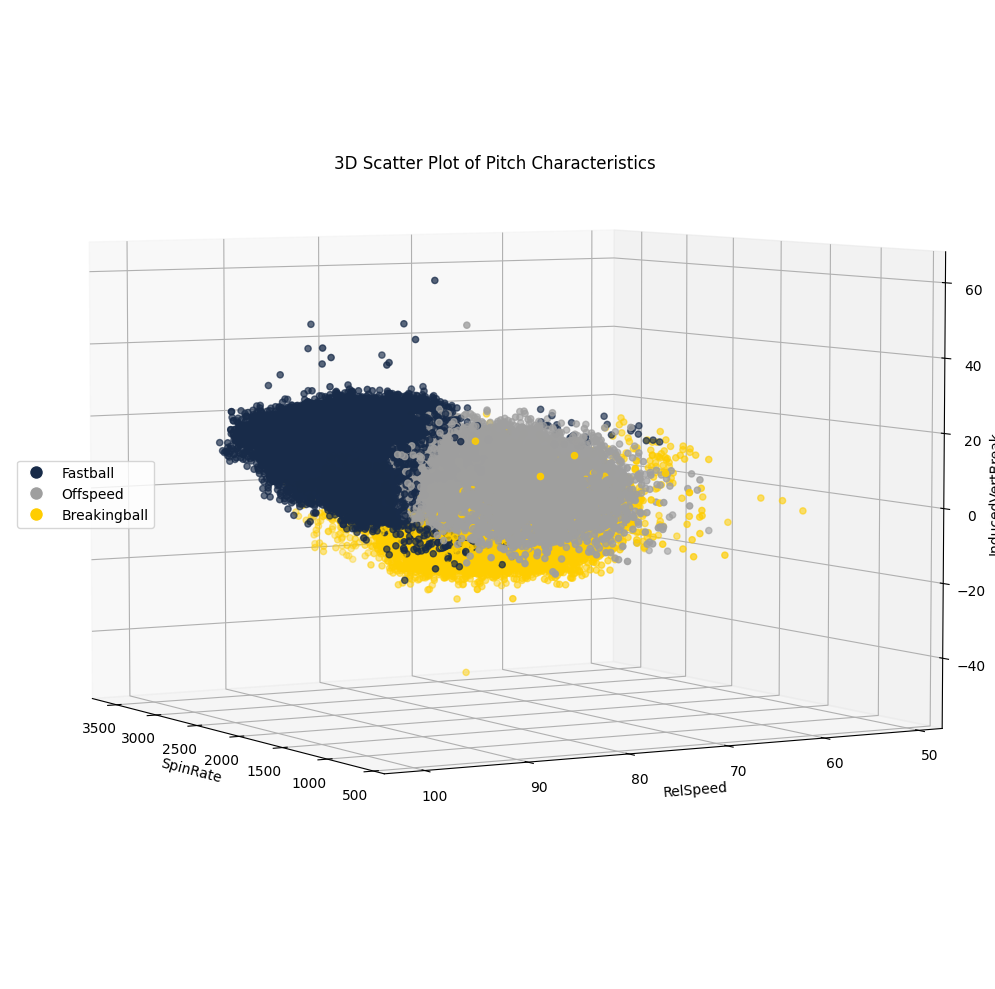

In [81]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

colors = training_data['AutoGroup'].map({'Breakingball': '#FFCD00', 'Fastball': '#182B49', 'Offspeed': '#9f9f9f'})

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Fastball', markerfacecolor='#182B49', markersize=10), 
                   Line2D([0], [0], marker='o', color='w', label='Offspeed', markerfacecolor='#9f9f9f', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Breakingball', markerfacecolor='#FFCD00', markersize=10),
                   ]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(training_data['SpinRate'], training_data['RelSpeed'], training_data['InducedVertBreak'], c=colors, marker='o')
ax.set_xlabel('SpinRate')
ax.set_ylabel('RelSpeed')
ax.set_zlabel('InducedVertBreak', labelpad=0)
ax.set_title('3D Scatter Plot of Pitch Characteristics', y=0.9)
ax.view_init(elev=5, azim=150)
ax.legend(handles=legend_elements, loc='center left')
plt.tight_layout()
plt.show()

## Pitch Group Model

Setting up the training set

In [82]:
group_training_data = training_data.copy()
group_training_data['group_cat_code'] = group_training_data['TaggedGroup'].astype('category').cat.codes
group_training_data['pitch_cat_code'] = group_training_data['TaggedPitchType'].astype('category').cat.codes

In [83]:
lhp = group_training_data[group_training_data['PitcherThrows']==0].reset_index(drop=True).copy()
group_X_lhp = (lhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               ).values
group_y_lhp = lhp['group_cat_code'].values

rhp = group_training_data[group_training_data['PitcherThrows']==1].reset_index(drop=True).copy()
group_X_rhp = (rhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               ).values
group_y_rhp = rhp['group_cat_code'].values

In [84]:
def xgboost_model(X, y):
    """
    Using an xgboost classifier model with bayesian optimization hypertuning to classify pitch type
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    xgb = XGBClassifier(objective="multi:softprob", num_class=3, eval_metric="mlogloss", tree_method="hist", random_state=42)

    param_grid = {"n_estimators": (100, 500), ## num of trees in the model
                "learning_rate": (0.01, 0.3, "log-uniform"), ## the rate at which the model makes changes to the weights
                "max_depth": (3, 7), ## how deep the trees can be
                "min_child_weight": (0.1, 5, "log-uniform"), ## min num of obs can be present in each node of the tree
                "subsample": (0.7, 0.9), ## num of obs used to build each tree
                "colsample_bytree": (0.6, 1.0), ## num of features used to build each tree
                "reg_alpha": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l1)
                "reg_lambda": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l2)
                "gamma": (0.0, 2.0), ## min loss reduction required to make a split
                }

    ## 3-fold stratified cv with bayesian optimization hypertuning to find the best xgboost model
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    opt = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=20, cv=cv, n_jobs=-1, scoring="neg_log_loss", verbose=0, random_state=42, refit=True)
    opt.fit(X_train, y_train)

    ## final training with validation split: checking generalization
    best_xgb = opt.best_estimator_
    best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_val_prob = best_xgb.predict_proba(X_val)
    y_val_pred = best_xgb.predict(X_val)

    ## evaluation metrics
    print("Log loss:", log_loss(y_val, y_val_prob))
    print("Accuracy:", accuracy_score(y_val, y_val_pred))

    ## confusion matrix for the model's results
    cat_dtype = group_training_data['TaggedGroup'].astype('category')
    class_names = cat_dtype.cat.categories.tolist()
    xgb_cm = confusion_matrix(y_val, y_val_pred)
    xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("XGBoost Validation Confusion Matrix")
    plt.show()

    ## displays the importance of each feature used (# is the # of times each feature is used in splits across the trees)
    feature_names = ['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']
    best_xgb.get_booster().feature_names = feature_names
    plot_importance(best_xgb, max_num_features=7)
    plt.show()

    return best_xgb

Log loss: 0.011125940556257971
Accuracy: 0.9960998439937597


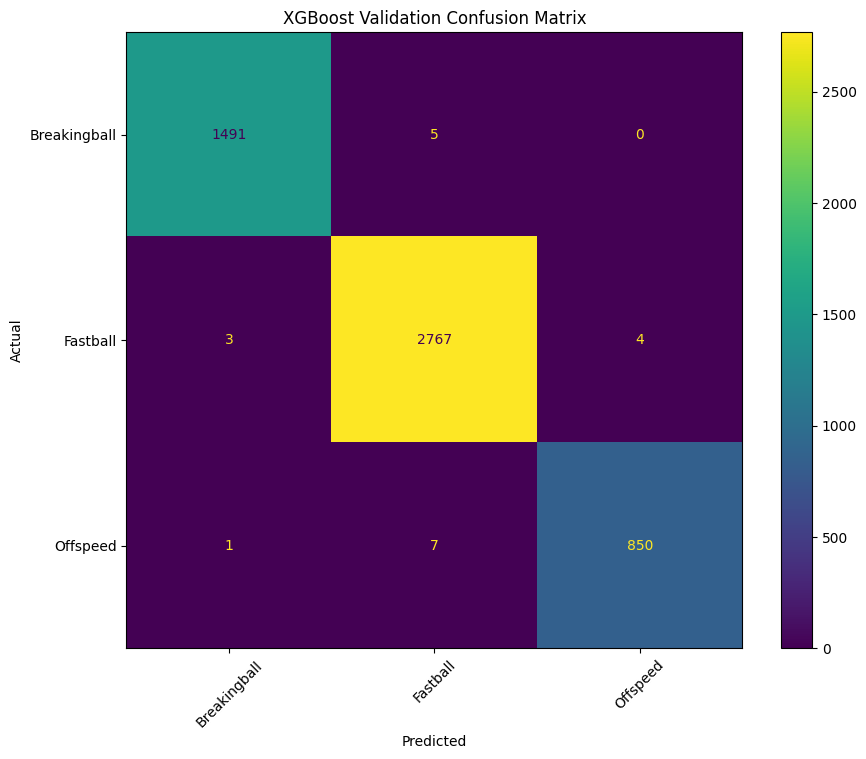

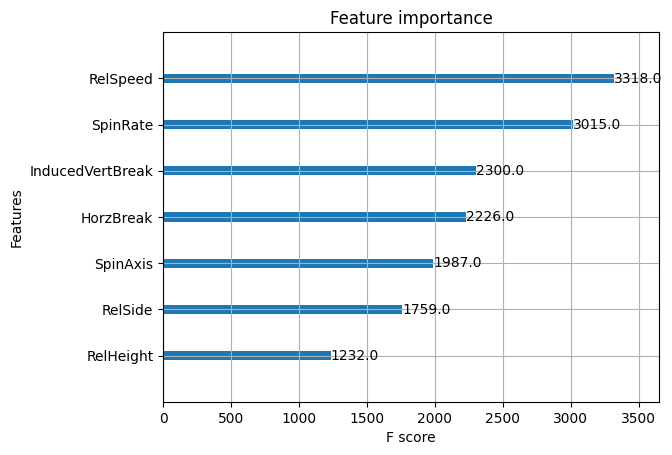

In [30]:
lhp_xgb = xgboost_model(group_X_lhp, group_y_lhp)

Log loss: 0.010211267871695283
Accuracy: 0.9960934998398976


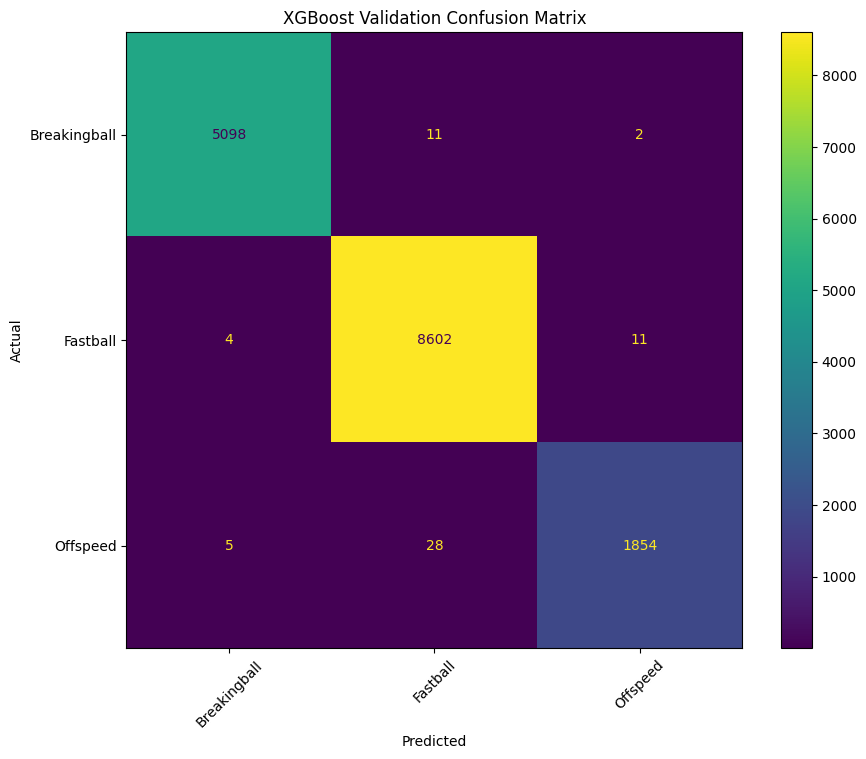

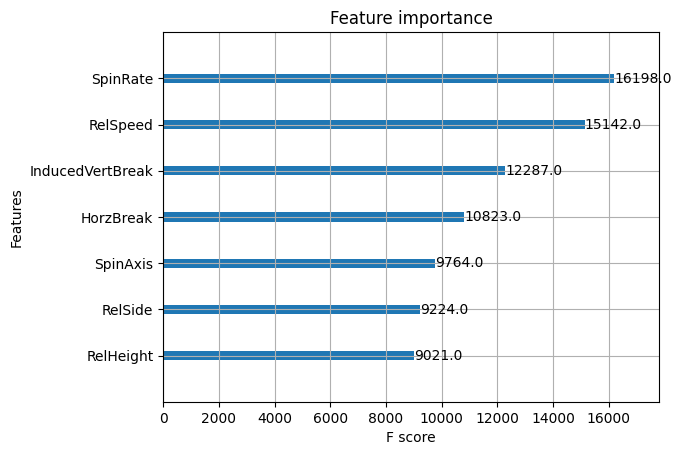

In [31]:
rhp_xgb = xgboost_model(group_X_rhp, group_y_rhp)

Evaluating the model

In [32]:
joblib.dump(lhp_xgb, "lhp_xgb.pkl")
lhp_xgb = joblib.load("lhp_xgb.pkl")
display(lhp_xgb)

joblib.dump(rhp_xgb, "rhp_xgb.pkl")
rhp_xgb = joblib.load("rhp_xgb.pkl")
display(rhp_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9268658686103153, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03513917557915234,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=0.3384379213998223, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=409,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.948875831160276, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.033380020524966546,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1.3561579072752339, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [33]:
display(group_training_data
        .groupby(['group_cat_code', 'PitcherThrows'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
        .mean()
        )
display(group_training_data
        .groupby(['group_cat_code', 'PitcherThrows'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
        .std()
        )

RelSpeed     SpinRate    SpinAxis  \
group_cat_code PitcherThrows                                       
0              0              77.270278  2315.874382  275.442682   
               1              79.034738  2378.078753   85.467456   
1              0              88.937414  2176.800214  144.898878   
               1              90.128630  2221.486559  215.894137   
2              0              79.711891  1697.065534  111.883941   
               1              81.493011  1707.608825  248.809768   

                              InducedVertBreak  HorzBreak  RelHeight   RelSide  
group_cat_code PitcherThrows                                                    
0              0                     -1.788326   8.761176   5.639507 -1.864284  
               1                     -1.782249  -8.825085   5.708904  1.759900  
1              0                     16.382387 -11.068770   5.787032 -1.670575  
               1                     16.133189  10.975465   5.839786  1.608609  
2              0                      7.514378 -15.151948   5.575943 -1.920034  
               1                      7.303776  15.015276   5.659093  1.780262

RelSpeed    SpinRate   SpinAxis  \
group_cat_code PitcherThrows                                    
0              0              3.733595  273.501896  55.899962   
               1              3.881160  265.032482  54.038289   
1              0              2.413932  158.516108  19.649398   
               1              2.607715  164.308006  20.846540   
2              0              3.373255  315.186144  22.860353   
               1              3.289050  341.150185  21.971763   

                              InducedVertBreak  HorzBreak  RelHeight   RelSide  
group_cat_code PitcherThrows                                                    
0              0                      6.418460   5.983863   0.528740  0.847509  
               1                      6.829445   5.983262   0.571959  0.729699  
1              0                      4.744063   5.698285   0.486864  0.776915  
               1                      5.152950   5.638035   0.519482  0.710644  
2              0                      5.474937   5.052731   0.468421  0.750665  
               1                      5.482536   4.592460   0.560159  0.690228

In [107]:
def prob_df(model, df, handedness, label_col="TaggedGroup"):
    """
    
    """
    X_pred_group = df[df['PitcherThrows'] == handedness].reset_index(drop=True).copy()
    
    cat_dtype = training_data[label_col].astype('category')
    classes = cat_dtype.cat.categories.tolist()
    
    X_pred_group['group_cat_code'] = training_data['TaggedGroup'].astype('category').cat.codes
    X_pred_group = (X_pred_group[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].transform(lambda x: (x - x.mean()) / x.std()))
    probs = model.predict_proba(X_pred_group.values)
    class_labels = [classes[i] for i in model.classes_]
    probs_df = pd.DataFrame(probs, columns=[f"p_{c}" for c in class_labels])
    probs_df = probs_df.round(3)

    training_data_w_prob = pd.concat([df[df['PitcherThrows'] == handedness].reset_index(drop=True), probs_df], axis=1)
    
    return training_data_w_prob

In [108]:
test_data = df[df['TaggedGroup'] != df['AutoGroup']].reset_index(drop=True).copy()
test_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup
0,206,2025-02-21,16:01:34.59,5,2,"Faulkner, Gavin",1.000069e+09,0,EKU_COL,"Humphrey, Isaac",8.042530e+05,Left,OLE_REB,Undefined,6,Bottom,1,1,0,Four-Seam,Changeup,BallCalled,Undefined,Undefined,Undefined,0,0,85.95471,-1.594255,0.818309,2079.724997,131.224731,10:15,6.05174,-1.26790,6.09295,-23.14356,14.91765,-15.45375,2.64789,-1.79872,77.63471,-5.980074,-1.967286,0.444030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.35678,8.63052,1.21335,50.0,5.91678,-1.18557,-124.74009,-4.14732,12.94124,29.10745,-18.80893,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,6a9a5420-f09f-11ef-b516-25f8a7d41699,84.88708,NaN,NaN,8.32000,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,22:01:34.59,2025-02-21T16:01:34.5967104-06:00,2025-02-21T22:01:34.5967104Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,c968ec51-4549-4b74-8bed-00ca9a22384e,54.40819,-125.76451,14.55372,6.05109,-3.48535,-9.40447,1.26309,-1.64103,6.47062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Offspeed
1,230,2025-02-21,16:16:43.52,2,1,"Morris, Mason",7.025680e+05,1,OLE_REB,"Alana, Diego",1.000116e+09,Left,EKU_COL,Undefined,7,Top,1,0,0,Cutter,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,89.46334,-2.320015,-1.608645,2495.027230,163.741140,11:30,6.19947,1.69193,5.90381,-27.70273,7.27079,-1.79614,1.73520,0.04854,82.05024,-7.442779,-1.931317,0.425639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46520,4.72677,-1.56159,50.0,5.99705,3.72178,-129.82251,-6.21201,0.79276,27.55537,-24.11919,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,8860f070-f0a1-11ef-b516-25f8a7

## Individual Pitch Model

In [109]:
merged_df = (pd.concat([prob_df(rhp_xgb, training_data, 1), 
                       prob_df(lhp_xgb, training_data, 0), 
                       prob_df(rhp_xgb, test_data, 1), 
                       prob_df(lhp_xgb, test_data, 0)])
                       .reset_index(drop=True)
                       .copy()
                       )
merged_df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,16,2025-02-21,14:11:11.82,1,1,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,91.57195,-2.628586,-3.174826,2207.441249,223.493945,1:30,5.92754,1.62175,6.23650,-16.31336,16.70143,14.82485,2.13779,-0.07463,83.63026,-5.743706,-0.500993,0.413548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.52898,9.70662,-1.39160,50.0,5.72280,6.74045,-132.78428,-6.55979,-15.21685,28.61852,-14.85611,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,ff2f8a70-f08f-11ef-b516-25f8a7d41699,91.14411,NaN,NaN,7.94169,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:11.82,2025-02-21T14:11:11.8251008-06:00,2025-02-21T20:11:11.8251008Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,dc191950-da93-4970-8769-e446650cd580,54.26343,-133.70000,14.30926,5.92509,-6.08443,-7.42805,-1.61507,7.22735,-7.60842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000
1,17,2025-02-21,14:11:28.90,1,2,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,91.33341,-2.816226,-2.792579,2047.277805,223.347860,1:30,5.76786,1.81151,6.09892,-16.98749,16.37654,14.42918,1.74231,0.42904,83.43171,-6.043673,-0.195299,0.415729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.20339,9.56292,-1.60374,50.0,5.54163,5.84703,-132.43500,-7.01774,-14.55291,28.57963,-15.20932,OLE_REB,E

In [110]:
training_data_indiv = merged_df[merged_df['TaggedPitchType'] == merged_df['AutoPitchType']].reset_index(drop=True).copy()
training_data_indiv

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,16,2025-02-21,14:11:11.82,1,1,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,91.57195,-2.628586,-3.174826,2207.441249,223.493945,1:30,5.92754,1.62175,6.23650,-16.31336,16.70143,14.82485,2.13779,-0.07463,83.63026,-5.743706,-0.500993,0.413548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.52898,9.70662,-1.39160,50.0,5.72280,6.74045,-132.78428,-6.55979,-15.21685,28.61852,-14.85611,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,ff2f8a70-f08f-11ef-b516-25f8a7d41699,91.14411,NaN,NaN,7.94169,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:11.82,2025-02-21T14:11:11.8251008-06:00,2025-02-21T20:11:11.8251008Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,dc191950-da93-4970-8769-e446650cd580,54.26343,-133.70000,14.30926,5.92509,-6.08443,-7.42805,-1.61507,7.22735,-7.60842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000
1,18,2025-02-21,14:11:44.93,1,3,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,1,1,Changeup,Changeup,BallCalled,Undefined,Undefined,Undefined,0,0,83.85827,-0.843377,-1.406615,1784.528129,265.139924,2:45,5.50880,1.81538,6.11002,-36.65037,2.86567,18.69273,1.67444,2.07215,76.78886,-7.631068,1.967652,0.452437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.98678,2.15815,-1.71650,50.0,5.42525,2.25403,-121.83576,-2.97885,-14.94152,24.97444,-28.94520,OLE_REB,EK

In [111]:
indiv_training_data = training_data_indiv.copy()
indiv_training_data['pitch_cat_code'] = indiv_training_data['TaggedPitchType'].astype('category').cat.codes

In [112]:
lhp = indiv_training_data[indiv_training_data['PitcherThrows']==0].reset_index(drop=True).copy()
indiv_X_lhp = (lhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               )
indiv_X_lhp.loc[:, 'p_Breakingball'] = lhp['p_Breakingball']
indiv_X_lhp.loc[:, 'p_Fastball'] = lhp['p_Fastball']
indiv_X_lhp.loc[:, 'p_Offspeed'] = lhp['p_Offspeed']
indiv_X_lhp = indiv_X_lhp.values
indiv_y_lhp = lhp['pitch_cat_code'].values

rhp = indiv_training_data[indiv_training_data['PitcherThrows']==1].reset_index(drop=True).copy()
indiv_X_rhp = (rhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               )
indiv_X_rhp.loc[:, 'p_Breakingball'] = rhp['p_Breakingball']
indiv_X_rhp.loc[:, 'p_Fastball'] = rhp['p_Fastball']
indiv_X_rhp.loc[:, 'p_Offspeed'] = rhp['p_Offspeed']
indiv_X_rhp = indiv_X_rhp.values
indiv_y_rhp = rhp['pitch_cat_code'].values

In [113]:
def xgboost_model_indiv(X, y):
    """
    Using an xgboost classifier model with bayesian optimization hypertuning to classify pitch type
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    xgb = XGBClassifier(objective="multi:softprob", num_class=7, eval_metric="mlogloss", tree_method="hist", random_state=42)

    param_grid = {"n_estimators": (100, 500), ## num of trees in the model
                "learning_rate": (0.01, 0.3, "log-uniform"), ## the rate at which the model makes changes to the weights
                "max_depth": (3, 7), ## how deep the trees can be
                "min_child_weight": (0.1, 5, "log-uniform"), ## min num of obs can be present in each node of the tree
                "subsample": (0.7, 0.9), ## num of obs used to build each tree
                "colsample_bytree": (0.6, 1.0), ## num of features used to build each tree
                "reg_alpha": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l1)
                "reg_lambda": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l2)
                "gamma": (0.0, 2.0), ## min loss reduction required to make a split
                }

    ## 3-fold stratified cv with bayesian optimization hypertuning to find the best xgboost model
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    opt = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=20, cv=cv, n_jobs=-1, scoring="neg_log_loss", verbose=0, random_state=42, refit=True)
    opt.fit(X_train, y_train)

    ## final training with validation split: checking generalization
    best_xgb = opt.best_estimator_
    best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_val_prob = best_xgb.predict_proba(X_val)
    y_val_pred = best_xgb.predict(X_val)

    ## evaluation metrics
    print("Log loss:", log_loss(y_val, y_val_prob))
    print("Accuracy:", accuracy_score(y_val, y_val_pred))

    ## confusion matrix for the model's results
    cat_dtype = group_training_data['TaggedPitchType'].astype('category')
    class_names = cat_dtype.cat.categories.tolist()
    xgb_cm = confusion_matrix(y_val, y_val_pred)
    xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("XGBoost Validation Confusion Matrix")
    plt.show()

    ## displays the importance of each feature used (# is the # of times each feature is used in splits across the trees)
    feature_names = ['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'p_Breakingball', 'p_Fastball', 'p_Offspeed']
    best_xgb.get_booster().feature_names = feature_names
    plot_importance(best_xgb, max_num_features=10)
    plt.show()

    return best_xgb

Log loss: 0.045195649752695334
Accuracy: 0.9843148046230049


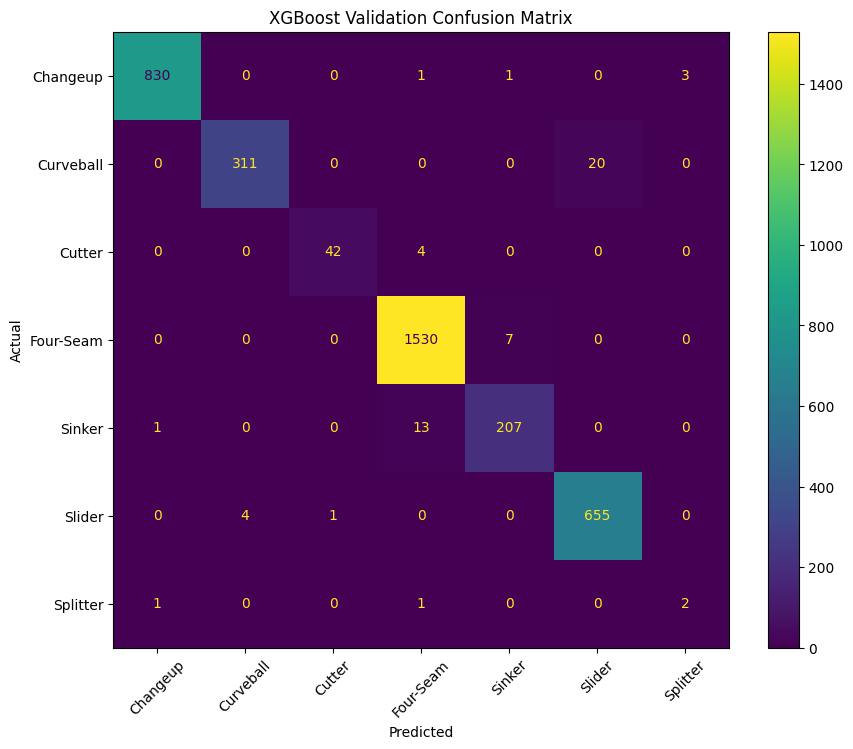

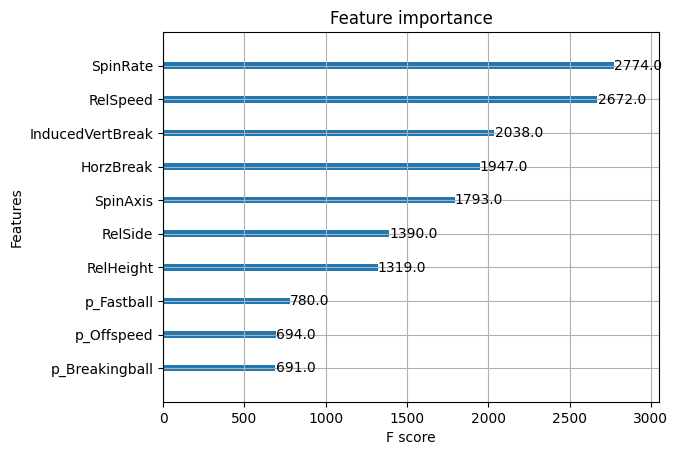

In [114]:
lhp_indiv_xgb = xgboost_model_indiv(indiv_X_lhp, indiv_y_lhp)

Log loss: 0.029677581055256197
Accuracy: 0.9902969468841489


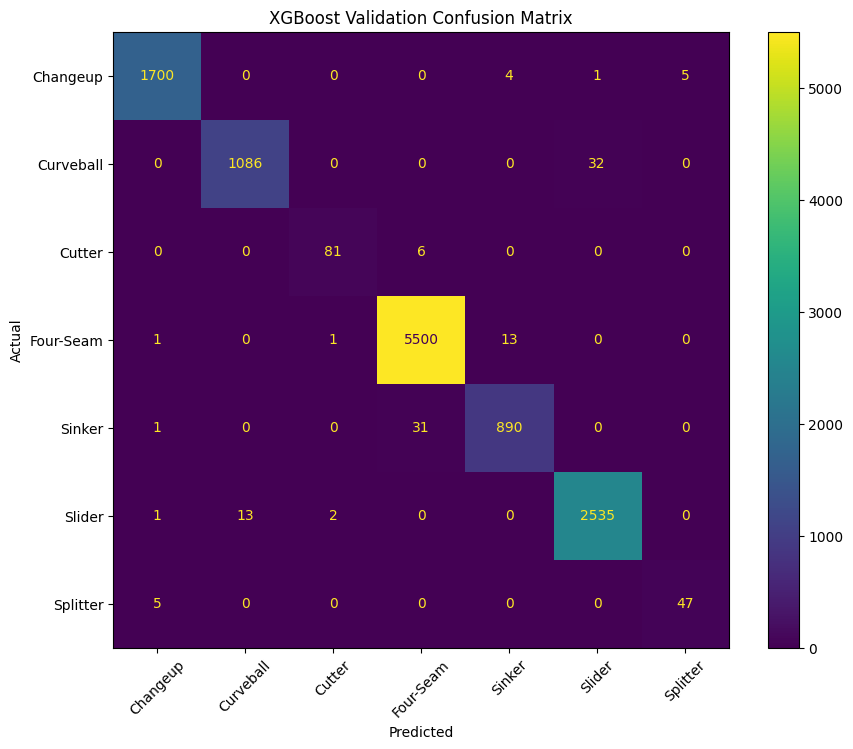

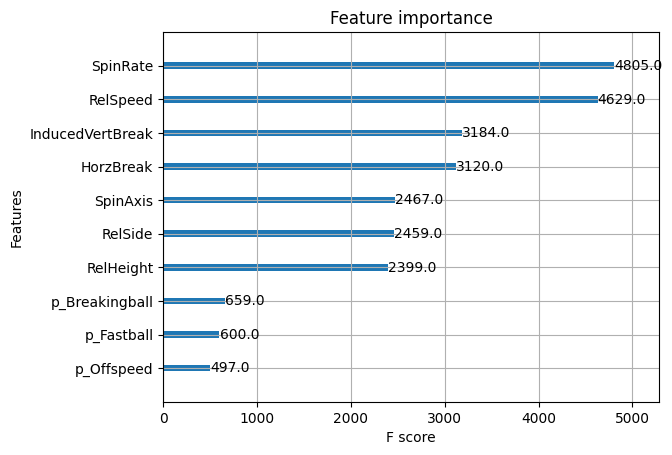

In [115]:
rhp_indiv_xgb = xgboost_model_indiv(indiv_X_rhp, indiv_y_rhp)

In [119]:
joblib.dump(lhp_indiv_xgb, "lhp_indiv_xgb.pkl")
lhp_indiv_xgb = joblib.load("lhp_indiv_xgb.pkl")
display(lhp_indiv_xgb)

joblib.dump(rhp_indiv_xgb, "rhp_indiv_xgb.pkl")
rhp_indiv_xgb = joblib.load("rhp_indiv_xgb.pkl")
display(rhp_indiv_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9198213766428692, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.8760583728818467, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05996280567850356,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3.4325554335927415, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=387,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.3535633487710165, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1295825385608945, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.33490374533098777, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

In [117]:
def prob_indiv_df(model, df, handedness, label_col="TaggedPitchType"):
    """
    
    """
    df = df[df['PitcherThrows'] == handedness].reset_index(drop=True).copy()
    X_pred = df.copy()
    
    X_pred = (X_pred[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].transform(lambda x: (x - x.mean()) / x.std()))

    X_pred.loc[:, 'p_Breakingball'] = df['p_Breakingball']
    X_pred.loc[:, 'p_Fastball'] = df['p_Fastball']
    X_pred.loc[:, 'p_Offspeed'] = df['p_Offspeed']

    cat_dtype = training_data[label_col].astype('category')
    code_to_label = dict(enumerate(cat_dtype.cat.categories))
    class_labels = [code_to_label[c] for c in model.classes_]

    probs = model.predict_proba(X_pred.values)
    probs_df = pd.DataFrame(probs, columns=[f"p_{c}" for c in class_labels])
    probs_df = probs_df.round(3)

    df_w_prob = pd.concat([df, probs_df], axis=1)
    
    return df_w_prob

In [120]:
test_indiv_data = merged_df[merged_df['TaggedPitchType'] != merged_df['AutoPitchType']].reset_index(drop=True).copy()
test_indiv_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,17,2025-02-21,14:11:28.90,1,2,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,91.33341,-2.816226,-2.792579,2047.277805,223.347860,1:30,5.76786,1.81151,6.09892,-16.98749,16.37654,14.42918,1.74231,0.42904,83.43171,-6.043673,-0.195299,0.415729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.20339,9.56292,-1.60374,50.0,5.54163,5.84703,-132.43500,-7.01774,-14.55291,28.57963,-15.20932,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,09570730-f090-11ef-b516-25f8a7d41699,90.66583,NaN,NaN,7.90170,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:28.90,2025-02-21T14:11:28.9018368-06:00,2025-02-21T20:11:28.9018368Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,938d3dfa-578f-4268-93a3-aa8d2a0b0d7e,54.40126,-133.38142,14.28982,5.76568,-6.51408,-7.60466,-1.80534,6.32895,-7.27645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000
1,19,2025-02-21,14:12:00.87,1,4,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,2,1,Four-Seam,Sinker,InPlay,Undefined,GroundBall,Out,1,0,89.88925,-2.068730,-1.714872,2175.680699,227.578542,1:30,5.66766,1.73860,6.01795,-19.82875,14.70902,14.85438,2.09728,1.38748,82.01262,-5.811790,0.957902,0.422979,60.16180,-66.419896,19.253788,NaN,NaN,NaN,NaN,1.22880,1.22880,-68.373974,0.023608,-8.14071,8.50575,-1.61221,50.0,5.49457,3.28482,-130.47528,-5.32263,-13.98214,28.386

In [121]:
prob_indiv_df(lhp_indiv_xgb, test_indiv_data, 0)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter
0,1,2025-02-21,14:02:52.36,1,1,"Elliott, Hunter",6.955450e+05,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,0,Four-Seam,Sinker,StrikeCalled,Undefined,Undefined,Undefined,0,0,89.33355,-0.276997,4.350026,2203.614887,132.167696,10:30,5.22699,-2.68740,6.21670,-17.99422,17.21702,-17.58678,3.47110,-0.13083,80.25956,-3.747010,1.186737,0.427083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.39816,9.33898,2.36887,50.0,5.19704,-9.08953,-129.30922,-1.10744,17.34646,30.66937,-16.59455,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,d5791800-f08e-11ef-b516-25f8a7d41699,88.25556,NaN,NaN,9.07400,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:02:52.36,2025-02-21T14:02:52.3694080-06:00,2025-02-21T20:02:52.3694080Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Smithwick, Campbell",805802.0,Right,OLE_REB,ebd6f9a4-d844-4b8f-9733-c22c00229021,54.28077,-130.32058,15.33469,5.22454,-0.56022,-8.29728,2.67804,-9.66155,8.67323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000,0.000,0.000,0.000,0.899,0.100,0.000,0.000
1,2,2025-02-21,14:03:10.24,1,2,"Elliott, Hunter",6.955450e+05,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,88.90840,-2.228576,3.686879,2183.741757,129.629962,10:15,5.21500,-2.74463,6.52932,-18.22198,17.10166,-18.99836,1.64677,-0.94085,79.64732,-5.761843,0.242888,0.427764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [122]:
prob_indiv_df(rhp_indiv_xgb, test_indiv_data, 1)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter
0,17,2025-02-21,14:11:28.90,1,2,"Walton, Ryker",10288839.0,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,91.33341,-2.816226,-2.792579,2047.277805,223.347860,1:30,5.76786,1.81151,6.09892,-16.98749,16.37654,14.42918,1.74231,0.42904,83.43171,-6.043673,-0.195299,0.415729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.20339,9.56292,-1.60374,50.0,5.54163,5.84703,-132.43500,-7.01774,-14.55291,28.57963,-15.20932,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,09570730-f090-11ef-b516-25f8a7d41699,90.66583,NaN,NaN,7.90170,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:28.90,2025-02-21T14:11:28.9018368-06:00,2025-02-21T20:11:28.9018368Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,938d3dfa-578f-4268-93a3-aa8d2a0b0d7e,54.40126,-133.38142,14.28982,5.76568,-6.51408,-7.60466,-1.80534,6.32895,-7.27645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000,0.000,0.0,0.0,1.000,0.000,0.0,0.0
1,19,2025-02-21,14:12:00.87,1,4,"Walton, Ryker",10288839.0,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,2,1,Four-Seam,Sinker,InPlay,Undefined,GroundBall,Out,1,0,89.88925,-2.068730,-1.714872,2175.680699,227.578542,1:30,5.66766,1.73860,6.01795,-19.82875,14.70902,14.85438,2.09728,1.38748,82.01262,-5.811790,0.957902,0.422979,60.16180,-66.419896,19.253788,NaN,NaN,NaN,NaN,1.22880,1.22880,

In [ ]:
merged_trackman_games = (pd.concat([prob_indiv_df(rhp_indiv_xgb, training_data_indiv, 1), prob_indiv_df(lhp_indiv_xgb, training_data_indiv, 0), 
                                    prob_indiv_df(rhp_indiv_xgb, test_indiv_data, 1), prob_indiv_df(lhp_indiv_xgb, test_indiv_data, 0)])
                         .reset_index(drop=True)
                         .copy()
                         )
prob_cols = ["p_Changeup", "p_Curveball", "p_Cutter", "p_Four-Seam", "p_Sinker", "p_Slider", "p_Splitter"]
group_prob_cols = ['p_Breakingball', 'p_Fastball', 'p_Offspeed']
merged_trackman_games.loc[:, "predTaggedGroup"] = merged_trackman_games[group_prob_cols].idxmax(axis=1)
merged_trackman_games.loc[:, "predTaggedGroup"] = merged_trackman_games["predTaggedGroup"].apply(lambda x: str(x.split('_')[1]))
merged_trackman_games.loc[:, "predTaggedPitch"] = merged_trackman_games[prob_cols].idxmax(axis=1)
merged_trackman_games.loc[:, "predTaggedPitch"] = merged_trackman_games["predTaggedPitch"].apply(lambda x: str(x.split('_')[1]))

In [136]:
merged_trackman_games.to_csv('../../Files/pitch_class_trackman_games.csv')

https://medium.com/mlb-technology/mlb-pitch-classification-64a1e32ee079